Birleştirilmiş excelin uyumsuz satırlarını düzeltme:

In [ ]:
import pandas as pd

# Excel dosyasını yükle
file_path = "/content/birlesmis_excel_100k.xlsx"  # Excel dosyanızın tam yolunu buraya yazın
data = pd.read_excel(file_path)

# Yeni bir DataFrame oluştur
merged_rows = []
columns_1 = ["Uzaktan/Normal", "Çalışma Şekli", "Yetenekler", "Konum", "İstenen Tecrübe", "Eğitim Seviyesi"]
columns_2 = ["DERECE", "ÖNE ÇIKAN PROJE", "SERTİFİKA ADI", "YETENEKLER", "DİL", "GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI", "konum", "Çalışma Şekli2", "Çalışma Türü", "ÇALIŞMA ZAMANI (YIL)"]

# Satırları kontrol ederek birleştir
for i in range(len(data) - 1):
    row1 = data.iloc[i]
    row2 = data.iloc[i + 1]

    # Eğer birinci satır columns_1 sütunlarına, ikinci satır columns_2 sütunlarına sahipse
    if not row1[columns_1].isnull().all() and not row2[columns_2].isnull().all():
        # İki satırı birleştir
        merged_row = row1.combine_first(row2)
        merged_rows.append(merged_row)

# Yeni DataFrame oluştur
merged_df = pd.DataFrame(merged_rows)

# Yeni dosyayı kaydet
output_file = "merged_output.xlsx"
merged_df.to_excel(output_file, index=False)

print(f"Birleştirilmiş veriler '{output_file}' olarak kaydedildi.")

Birleştirilmiş veriler 'merged_output.xlsx' olarak kaydedildi.


Etiketleme işlemi:

In [ ]:
import pandas as pd

# Eğitim seviyesi sıralaması
education_levels = ["ön lisans", "lisans", "yüksek lisans", "doktora"]

# Eğitim seviyesini sıralamada bulmak için yardımcı fonksiyon
def get_education_rank(education):
    if pd.isna(education):
        return -1  # Belirtilmemişse
    education_list = [ed.strip() for ed in str(education).split(",")]
    ranks = [education_levels.index(ed) for ed in education_list if ed in education_levels]
    return max(ranks, default=-1)  # En yüksek seviyesi

# Eğitim seviyesi kontrolü
def check_education(cv_education, job_education):
    cv_rank = get_education_rank(cv_education)
    job_rank = get_education_rank(job_education)

    if cv_rank == -1:
        return 0  # CV'de eğitim seviyesi belirtilmemişse
    if job_rank == -1 or cv_rank >= job_rank:
        return 1  # İş ilanında belirtilmemiş veya CV seviyesi yeterliyse
    return 0  # CV seviyesi iş ilanına uygun değilse

# Çalışma yeri ve süresi eşleşmesi
def check_work_place_and_duration(job_row, cv_row):
    return job_row["Uzaktan/Normal"] == cv_row["Çalışma Şekli2"] and job_row["Çalışma Şekli"] == cv_row["Çalışma Türü"]

# Konum eşleşmesi
def check_location(job_row, cv_row):
    cv_location = cv_row["konum"]
    job_locations = str(job_row["Konum"]).split(",")  # İş ilanındaki iller virgülle ayrılmış olabilir
    return cv_location in job_locations

# Tecrübe eşleşmesi
def check_experience(job_row, cv_row):
    job_experience = job_row["İstenen Tecrübe"]
    cv_experience = cv_row["ÇALIŞMA ZAMANI (YIL)"]

    if pd.isna(cv_experience):
        return False  # CV'de tecrübe belirtilmemişse uygun olmadığını varsayın

    if pd.isna(job_experience) or str(job_experience).strip() == "":
        return True  # İş ilanında tecrübe belirtilmemişse uygun olduğunu varsayın

    try:
        if " ile " in str(job_experience):  # Örnek: "5 ile 10"
            min_exp, max_exp = map(int, str(job_experience).split(" ile "))
            return min_exp <= cv_experience <= max_exp
        else:  # Tek bir sayı belirtilmişse
            min_exp = int(job_experience)
            return cv_experience >= min_exp
    except ValueError:
        return False  # Beklenmeyen bir format varsa uygun olmadığını varsayın

# Yetenekler eşleşme oranı
def check_skills(job_row, cv_row):
    job_skills = set(str(job_row["Yetenekler"]).split(","))
    cv_skills = set(str(cv_row["YETENEKLER"]).split(","))
    if not job_skills or not cv_skills:
        return 0  # Yeteneklerden biri belirtilmemişse eşleşme olmaz
    matching_skills = job_skills.intersection(cv_skills)
    return len(matching_skills) / len(job_skills)  # İş ilanındaki yeteneklerin ne kadarına uyuluyor

# Ek özellik kontrolü (ÖNE ÇIKAN PROJE, SERTİFİKA ADI, GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI)
def check_additional_features(cv_row):
    score = 0
    if not pd.isna(cv_row["ÖNE ÇIKAN PROJE"]) and str(cv_row["ÖNE ÇIKAN PROJE"]).strip():
        score += 1  # Proje varsa 1 puan
    if not pd.isna(cv_row["SERTİFİKA ADI"]) and str(cv_row["SERTİFİKA ADI"]).strip():
        score += 1  # Sertifika varsa 1 puan
    if not pd.isna(cv_row["GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI"]) and str(cv_row["GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI"]).strip():
        score += 1  # Gönüllülük varsa 1 puan
    return score / 3  # Bu özelliklerin toplamı, eşleşme oranına katkıda bulunur (0 ile 1 arasında)

# Eşleşmeyi kontrol et
def calculate_match_percentage(job_row, cv_row):
    total_checks = 6
    matches = 0

    if check_work_place_and_duration(job_row, cv_row):
        matches += 1
    if check_location(job_row, cv_row):
        matches += 1
    if check_experience(job_row, cv_row):
        matches += 1
    if check_education(cv_row["DERECE"], job_row["Eğitim Seviyesi"]):
        matches += 1
    matches += check_skills(job_row, cv_row)  # Yetenekler eşleşme oranı (0 ile 1 arasında)
    matches += check_additional_features(cv_row)  # Ek özellikler eşleşme oranı (0 ile 1 arasında)

    return (matches / total_checks) * 100 if total_checks > 0 else 0

# Excel dosyasını yükle
file_name = "/content/merged_output.xlsx"
data = pd.read_excel(file_name)

# Her CV ve iş ilanı için eşleşme oranını hesapla
match_percentages = []
for _, row in data.iterrows():
    match_percentage = calculate_match_percentage(row, row)
    match_percentages.append(match_percentage)

# Eşleşme oranını yeni bir sütun olarak ekle
data["Eşleşme Oranı (%)"] = match_percentages

# Güncellenmiş Excel dosyasını kaydet
data.to_excel(file_name, index=False)

print(f"Eşleşme oranları '{file_name}' dosyasına kaydedildi.")


Eşleşme oranları '/content/merged_output.xlsx' dosyasına kaydedildi.


Algoritma olarak lightGBM kullanıp Özellik Çıkarımı için TF-IDF, Bag of Words ve Word2Vec kıyaslaması yapıldı.



1.   Cross validation
2.   Train test split




**Cross validation**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.244808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44615, number of negative: 45385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.201429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495722 -> initscore=-0.017112
[LightGBM] [Info] Start training from score -0.017112


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44615, number of negative: 45385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495722 -> initscore=-0.017112
[LightGBM] [Info] Start training from score -0.017112


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44615, number of negative: 45385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495722 -> initscore=-0.017112
[LightGBM] [Info] Start training from score -0.017112


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

TF-IDF - Cross Validation Mean F1 Score: 0.8947
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.211963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44615, number of negative: 45385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495722 -> initscore=-0.017112
[LightGBM] [Info] Start training from score -0.017112


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44615, number of negative: 45385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495722 -> initscore=-0.017112
[LightGBM] [Info] Start training from score -0.017112


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44615, number of negative: 45385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495722 -> initscore=-0.017112
[LightGBM] [Info] Start training from score -0.017112


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

BoW - Cross Validation Mean F1 Score: 0.8966
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44616, number of negative: 45384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495733 -> initscore=-0.017067
[LightGBM] [Info] Start training from score -0.017067


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44615, number of negative: 45385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495722 -> initscore=-0.017112
[LightGBM] [Info] Start training from score -0.017112


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44615, number of negative: 45385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495722 -> initscore=-0.017112
[LightGBM] [Info] Start training from score -0.017112


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 44615, number of negative: 45385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495722 -> initscore=-0.017112
[LightGBM] [Info] Start training from score -0.017112


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Word2Vec - Cross Validation Mean F1 Score: 0.7770


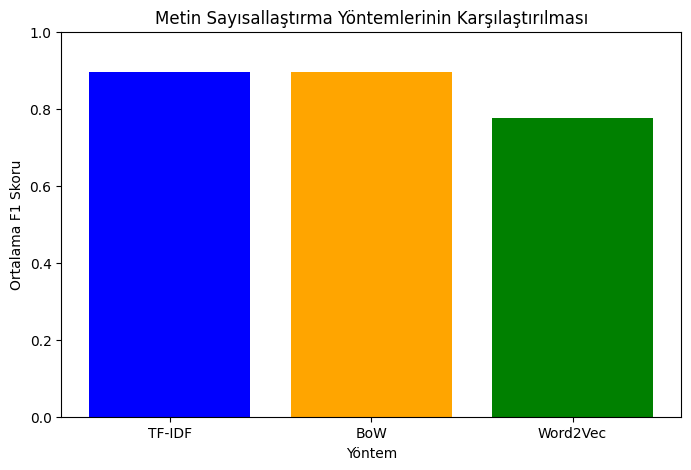

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

# Veri yükleme
file_name = "/content/data.xlsx"
data = pd.read_excel(file_name)

# Hedef sütunu ikili sınıfa çevirme
data['Target'] = data["Eşleşme Oranı (%)"].apply(lambda x: 1 if x > 49 else 0)

# Özellikler ve hedef sütunlar
text_columns = ["Yetenekler", "Konum", "DERECE", "Eğitim Seviyesi", "YETENEKLER", "DİL", "konum", "İstenen Tecrübe"]
numeric_columns = ["Çalışma Şekli2", "Çalışma Türü", "Uzaktan/Normal", "Çalışma Şekli", "ÇALIŞMA ZAMANI (YIL)", "ÖNE ÇIKAN PROJE", "SERTİFİKA ADI", "GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI"]

# Kategorik sütunları sayısallaştırma
data['Uzaktan/Normal'] = data['Uzaktan/Normal'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Şekli2'] = data['Çalışma Şekli2'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Türü'] = data['Çalışma Türü'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})
data['Çalışma Şekli'] = data['Çalışma Şekli'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})

# LightGBM modelini tanımlama ve sabit hiperparametreler
lgb_model = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=100, max_depth=10, num_leaves=31, random_state=42)

# BoW (Bag of Words) ile metni sayısallaştırma
bow_vectorizer = CountVectorizer(max_features=100)
bow_features = bow_vectorizer.fit_transform(data[text_columns].astype(str).agg(' '.join, axis=1)).toarray()
bow_df = pd.DataFrame(bow_features, columns=[f'bow_{i}' for i in range(bow_features.shape[1])])

# Word2Vec ile metni sayısallaştırma
def word2vec_transform(texts):
    tokenized_texts = [text.split() for text in texts]
    model = Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
    return np.array([np.mean([model.wv[word] for word in words if word in model.wv], axis=0) for words in tokenized_texts])

word2vec_features = word2vec_transform(data[text_columns].astype(str).agg(' '.join, axis=1))
word2vec_df = pd.DataFrame(word2vec_features, columns=[f'word2vec_{i}' for i in range(word2vec_features.shape[1])])

# TF-IDF ile metni sayısallaştırma
tfidf = TfidfVectorizer(max_features=100)
text_features = tfidf.fit_transform(data[text_columns].astype(str).agg(' '.join, axis=1)).toarray()
text_df = pd.DataFrame(text_features, columns=[f'tfidf_{i}' for i in range(text_features.shape[1])])

# Veriyi hazırlama
X_tfidf = pd.concat([data[numeric_columns].reset_index(drop=True), text_df.reset_index(drop=True)], axis=1)
X_bow = pd.concat([data[numeric_columns].reset_index(drop=True), bow_df.reset_index(drop=True)], axis=1)
X_word2vec = pd.concat([data[numeric_columns].reset_index(drop=True), word2vec_df.reset_index(drop=True)], axis=1)

# Model değerlendirme ve grafik için sonuçları toplama
methods = ['TF-IDF', 'BoW', 'Word2Vec']
X_datasets = [X_tfidf, X_bow, X_word2vec]
f1_scores = []

for method, X_data in zip(methods, X_datasets):
    # Çapraz doğrulama
    cv_scores = cross_val_score(lgb_model, X_data, data['Target'], cv=10, scoring='f1')
    mean_f1_score = np.mean(cv_scores)
    f1_scores.append(mean_f1_score)
    print(f"{method} - Cross Validation Mean F1 Score: {mean_f1_score:.4f}")

# Sonuçları görselleştirme
plt.figure(figsize=(8, 5))
plt.bar(methods, f1_scores, color=['blue', 'orange', 'green'])
plt.xlabel('Yöntem')
plt.ylabel('Ortalama F1 Skoru')
plt.title('Metin Sayısallaştırma Yöntemlerinin Karşılaştırılması')
plt.ylim(0, 1)  # Skorlar 0-1 arasında olduğu için y eksenini sınırlandırıyoruz
plt.show()


**SONUÇ**


*   TF-IDF - Cross Validation Mean F1 Score: 0.8947
*   BoW - Cross Validation Mean F1 Score: 0.8966
* Word2Vec - Cross Validation Mean F1 Score: 0.7770

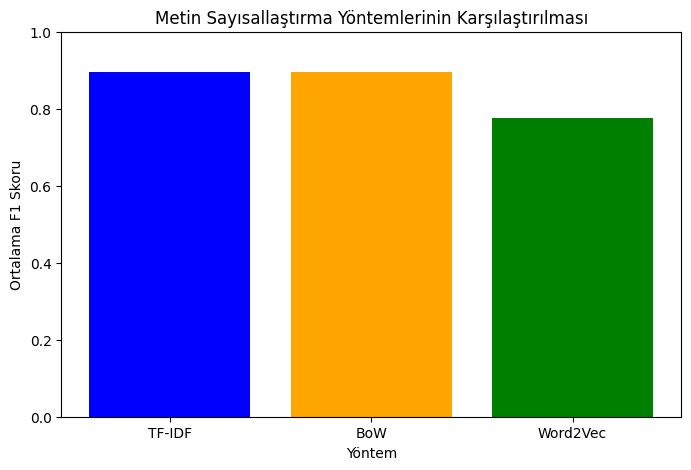





**Train test split**

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 39680, number of negative: 40320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.760931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496000 -> initscore=-0.016000
[LightGBM] [Info] Start training from score -0.016000

TF-IDF Performance:
Accuracy: 0.8977, Precision: 0.9209, Recall: 0.8677, F1-Score: 0.8935


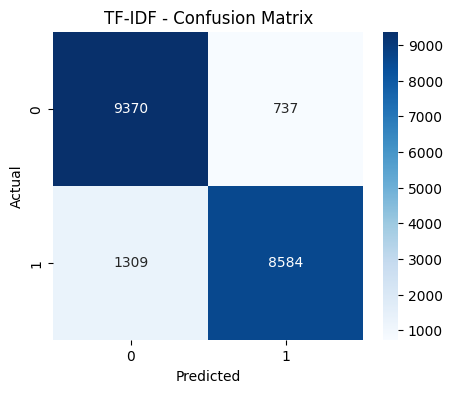

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 39680, number of negative: 40320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496000 -> initscore=-0.016000
[LightGBM] [Info] Start training from score -0.016000

Bag of Words (BoW) Performance:
Accuracy: 0.9024, Precision: 0.9278, Recall: 0.8704, F1-Score: 0.8982


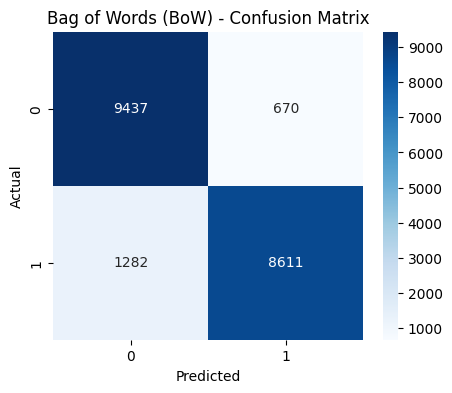

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 39680, number of negative: 40320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25532
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496000 -> initscore=-0.016000
[LightGBM] [Info] Start training from score -0.016000

Word2Vec Performance:
Accuracy: 0.7718, Precision: 0.7585, Recall: 0.7903, F1-Score: 0.7741


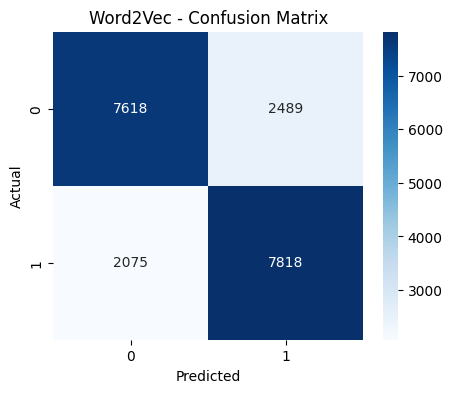

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

# Veri yükleme
file_name = "/content/data.xlsx"
data = pd.read_excel(file_name)

# Hedef sütunu ikili sınıfa çevirme
data['Target'] = data["Eşleşme Oranı (%)"].apply(lambda x: 1 if x > 49 else 0)

# Özellikler ve hedef sütunlar
text_columns = ["Yetenekler", "Konum", "DERECE", "Eğitim Seviyesi", "YETENEKLER", "DİL", "konum", "İstenen Tecrübe"]
numeric_columns = ["Çalışma Şekli2", "Çalışma Türü", "Uzaktan/Normal", "Çalışma Şekli", "ÇALIŞMA ZAMANI (YIL)", "ÖNE ÇIKAN PROJE", "SERTİFİKA ADI", "GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI"]

# Kategorik sütunları sayısallaştırma
data['Uzaktan/Normal'] = data['Uzaktan/Normal'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Şekli2'] = data['Çalışma Şekli2'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Türü'] = data['Çalışma Türü'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})
data['Çalışma Şekli'] = data['Çalışma Şekli'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})

# Text veriyi birleştirme
text_data = data[text_columns].astype(str).agg(' '.join, axis=1)

# Model tanımlama
def train_and_evaluate(X, y, method_name):
    # Veriyi eğitim ve test kümelerine ayırma
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # LightGBM modelini eğitme
    lgb_model = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=100, max_depth=10, num_leaves=31, random_state=42)
    lgb_model.fit(X_train, y_train)

    # Test kümesi üzerinde tahmin yapma
    y_pred = lgb_model.predict(X_test)

    # Değerlendirme metrikleri
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{method_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Karışıklık matrisi görselleştirme
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{method_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 1. TF-IDF
tfidf = TfidfVectorizer(max_features=100)
tfidf_features = tfidf.fit_transform(text_data).toarray()
X_tfidf = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(tfidf_features)], axis=1)
train_and_evaluate(X_tfidf, data['Target'], "TF-IDF")

# 2. Bag of Words (BoW)
bow = CountVectorizer(max_features=100)
bow_features = bow.fit_transform(text_data).toarray()
X_bow = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(bow_features)], axis=1)
train_and_evaluate(X_bow, data['Target'], "Bag of Words (BoW)")

# 3. Word2Vec
text_tokenized = text_data.str.split()
w2v_model = Word2Vec(sentences=text_tokenized, vector_size=100, window=5, min_count=1, workers=4)
w2v_features = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv] or [np.zeros(100)], axis=0) for words in text_tokenized])
X_w2v = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(w2v_features)], axis=1)
train_and_evaluate(X_w2v, data['Target'], "Word2Vec")


TF-IDF Performance:
Accuracy: 0.8977, Precision: 0.9209, Recall: 0.8677, F1-Score: 0.8935
 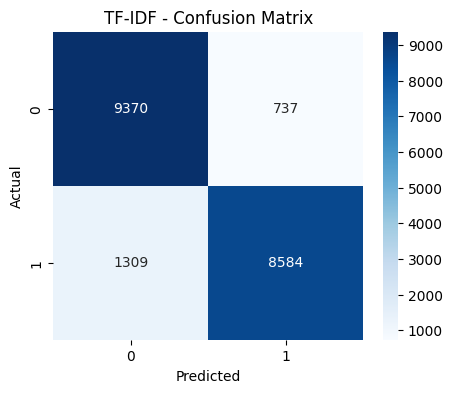

 Bag of Words (BoW) Performance:
Accuracy: 0.9024, Precision: 0.9278, Recall: 0.8704, F1-Score: 0.8982

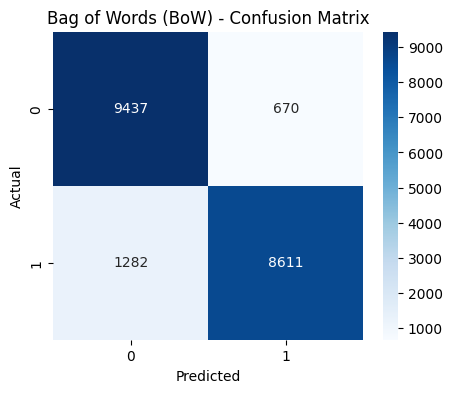

Word2Vec Performance:
Accuracy: 0.7718, Precision: 0.7585, Recall: 0.7903, F1-Score: 0.7741

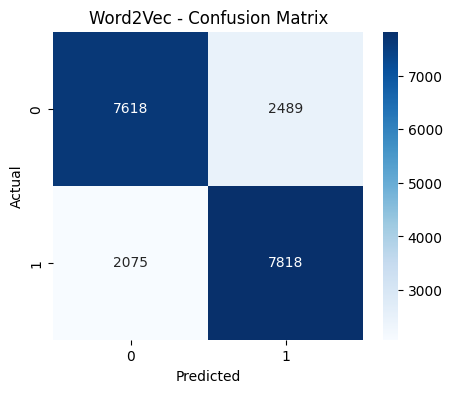

2) Algoritma olarak **Logistic Regression** kullanıp Özellik Çıkarımı için TF-IDF, Bag of Words ve Word2Vec kıyaslaması yapıldı.

* Cross validation
* Train test split

**Cross validation**

TF-IDF - Cross Validation Mean F1 Score: 0.6839
BoW - Cross Validation Mean F1 Score: 0.6855
Word2Vec - Cross Validation Mean F1 Score: 0.6637


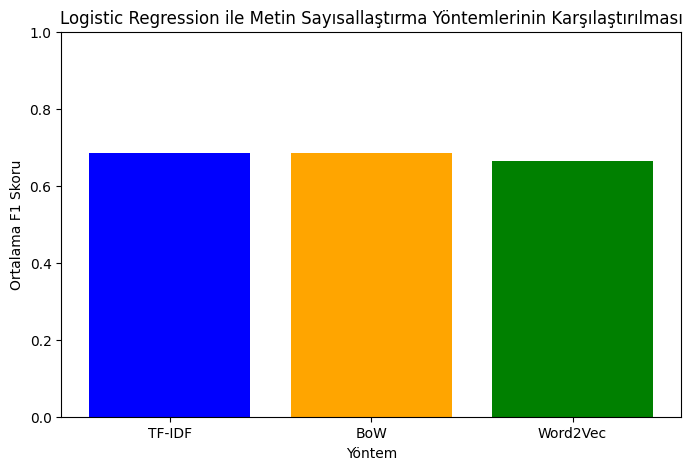

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

# Veri yükleme
file_name = "/content/data.xlsx"
data = pd.read_excel(file_name)

# Eksik değer analizi ve fazla eksik sütunları kaldırma
missing_counts = data.isnull().sum().sort_values(ascending=False)
columns_to_drop = missing_counts[missing_counts > (0.5 * len(data))].index
data.drop(columns=columns_to_drop, axis=1, inplace=True)

# Kalan eksik değerleri mod (en sık görülen değer) ile doldurma
data.fillna(data.mode().iloc[0], inplace=True)

# Hedef sütunu ikili sınıfa çevirme
data['Target'] = data["Eşleşme Oranı (%)"].apply(lambda x: 1 if x > 49 else 0)

# Özellikler ve hedef sütunlar
text_columns = [col for col in ["Yetenekler", "Konum", "DERECE", "Eğitim Seviyesi", "YETENEKLER", "DİL", "konum", "İstenen Tecrübe"] if col in data.columns]
numeric_columns = [col for col in ["Çalışma Şekli2", "Çalışma Türü", "Uzaktan/Normal", "Çalışma Şekli", "ÇALIŞMA ZAMANI (YIL)", "ÖNE ÇIKAN PROJE", "SERTİFİKA ADI", "GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI"] if col in data.columns]

# Kategorik sütunları sayısallaştırma
data['Uzaktan/Normal'] = data['Uzaktan/Normal'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Şekli2'] = data['Çalışma Şekli2'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Türü'] = data['Çalışma Türü'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})
data['Çalışma Şekli'] = data['Çalışma Şekli'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})

# Eksik değerleri doldurma
data[numeric_columns] = data[numeric_columns].fillna(0)
data[text_columns] = data[text_columns].fillna('')

# Logistic Regression modeli
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# BoW (Bag of Words)
bow_vectorizer = CountVectorizer(max_features=100)
bow_features = bow_vectorizer.fit_transform(data[text_columns].astype(str).agg(' '.join, axis=1)).toarray()
bow_df = pd.DataFrame(bow_features, columns=[f'bow_{i}' for i in range(bow_features.shape[1])])

# Word2Vec
def word2vec_transform(texts):
    tokenized_texts = [text.split() for text in texts]
    model = Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
    return np.array([np.mean([model.wv[word] for word in words if word in model.wv], axis=0) for words in tokenized_texts])

word2vec_features = word2vec_transform(data[text_columns].astype(str).agg(' '.join, axis=1))
word2vec_df = pd.DataFrame(word2vec_features, columns=[f'word2vec_{i}' for i in range(word2vec_features.shape[1])])

# TF-IDF
tfidf = TfidfVectorizer(max_features=100)
tfidf_features = tfidf.fit_transform(data[text_columns].astype(str).agg(' '.join, axis=1)).toarray()
tfidf_df = pd.DataFrame(tfidf_features, columns=[f'tfidf_{i}' for i in range(tfidf_features.shape[1])])

# Veriyi birleştirme
X_tfidf = pd.concat([data[numeric_columns].reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1).fillna(0)
X_bow = pd.concat([data[numeric_columns].reset_index(drop=True), bow_df.reset_index(drop=True)], axis=1).fillna(0)
X_word2vec = pd.concat([data[numeric_columns].reset_index(drop=True), word2vec_df.reset_index(drop=True)], axis=1).fillna(0)

# Model değerlendirme
methods = ['TF-IDF', 'BoW', 'Word2Vec']
X_datasets = [X_tfidf, X_bow, X_word2vec]
f1_scores = []

for method, X_data in zip(methods, X_datasets):
    cv_scores = cross_val_score(lr_model, X_data, data['Target'], cv=10, scoring='f1')
    mean_f1_score = np.mean(cv_scores)
    f1_scores.append(mean_f1_score)
    print(f"{method} - Cross Validation Mean F1 Score: {mean_f1_score:.4f}")

# Sonuçları görselleştirme
plt.figure(figsize=(8, 5))
plt.bar(methods, f1_scores, color=['blue', 'orange', 'green'])
plt.xlabel('Yöntem')
plt.ylabel('Ortalama F1 Skoru')
plt.title('Logistic Regression ile Metin Sayısallaştırma Yöntemlerinin Karşılaştırılması')
plt.ylim(0, 1)
plt.show()


* TF-IDF - Cross Validation Mean F1 Score: 0.6839
* BoW - Cross Validation Mean F1 Score: 0.6855
* Word2Vec - Cross Validation Mean F1 Score: 0.6637

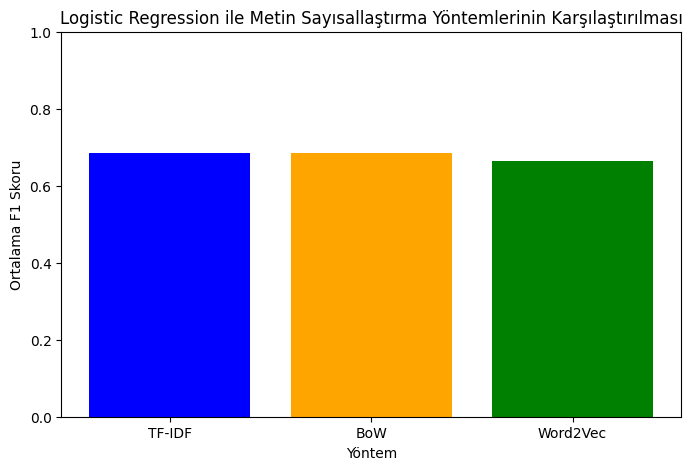

**Train test split**

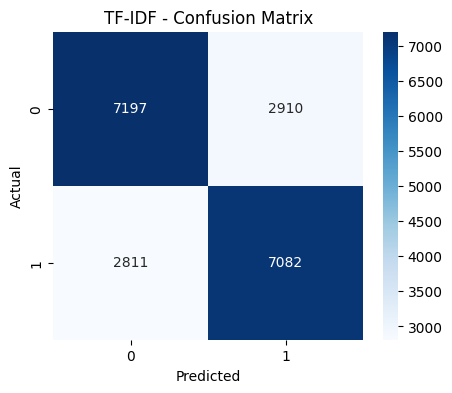

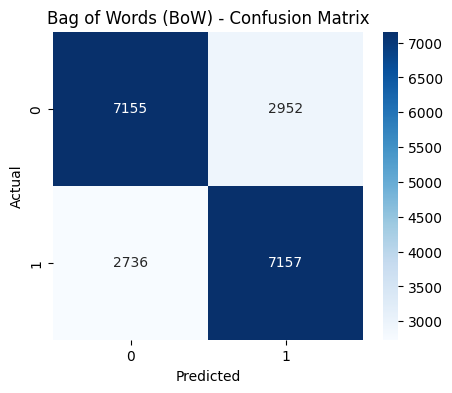

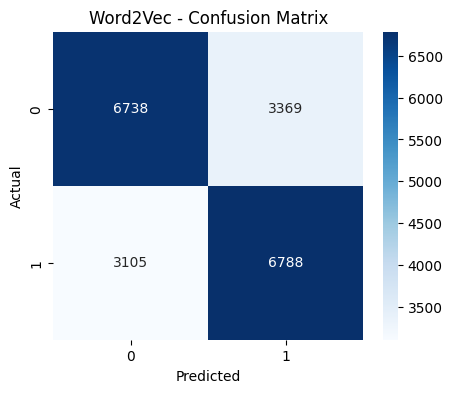


Değerlendirme Sonuçları:
               Method  Accuracy  Precision    Recall  F1-Score
0              TF-IDF   0.71395   0.708767  0.715860  0.712296
1  Bag of Words (BoW)   0.71560   0.707983  0.723441  0.715628
2            Word2Vec   0.67630   0.668308  0.686142  0.677107


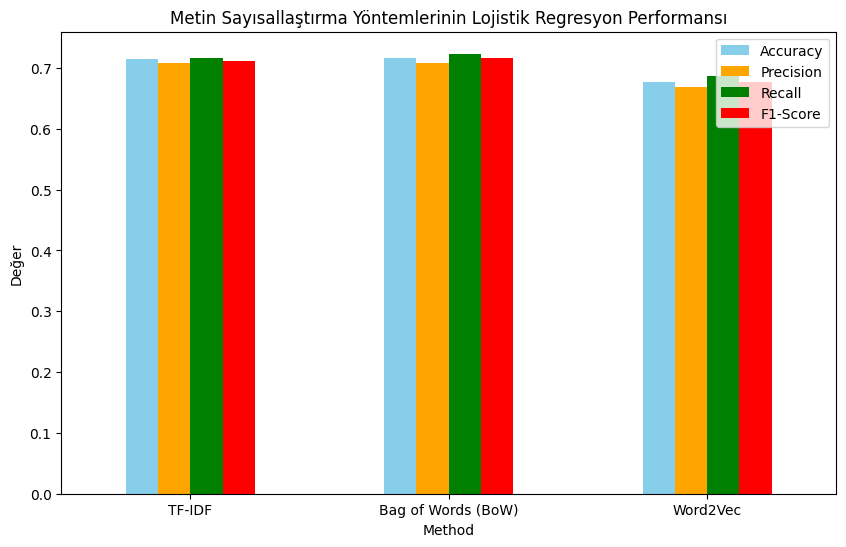

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

# Veri yükleme
file_name = "/content/data.xlsx"
data = pd.read_excel(file_name)

# Hedef sütunu ikili sınıfa çevirme
data['Target'] = data["Eşleşme Oranı (%)"].apply(lambda x: 1 if x > 49 else 0)

# Özellikler ve hedef sütunlar
text_columns = ["Yetenekler", "Konum", "DERECE", "Eğitim Seviyesi", "YETENEKLER", "DİL", "konum", "İstenen Tecrübe"]
numeric_columns = ["Çalışma Şekli2", "Çalışma Türü", "Uzaktan/Normal", "Çalışma Şekli", "ÇALIŞMA ZAMANI (YIL)", "ÖNE ÇIKAN PROJE", "SERTİFİKA ADI", "GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI"]

# Kategorik sütunları sayısallaştırma
data['Uzaktan/Normal'] = data['Uzaktan/Normal'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Şekli2'] = data['Çalışma Şekli2'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Türü'] = data['Çalışma Türü'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})
data['Çalışma Şekli'] = data['Çalışma Şekli'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})

# Text veriyi birleştirme
text_data = data[text_columns].astype(str).agg(' '.join, axis=1)

# Model tanımlama ve değerlendirme
results = []

def train_and_evaluate(X, y, method_name):
    global results
    # Veriyi eğitim ve test kümelerine ayırma
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Logistic Regression modelini eğitme
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)

    # Test kümesi üzerinde tahmin yapma
    y_pred = lr_model.predict(X_test)

    # Değerlendirme metrikleri
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Sonuçları saklama
    results.append({
        "Method": method_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

    # Karışıklık matrisi görselleştirme
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{method_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 1. TF-IDF
tfidf = TfidfVectorizer(max_features=100)
tfidf_features = tfidf.fit_transform(text_data).toarray()
X_tfidf = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(tfidf_features)], axis=1)
X_tfidf.columns = X_tfidf.columns.astype(str)
X_tfidf = X_tfidf.fillna(0)  # Eksik değerleri 0 ile doldur
train_and_evaluate(X_tfidf, data['Target'], "TF-IDF")

# 2. Bag of Words (BoW)
bow = CountVectorizer(max_features=100)
bow_features = bow.fit_transform(text_data).toarray()
X_bow = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(bow_features)], axis=1)
X_bow.columns = X_bow.columns.astype(str)
X_bow = X_bow.fillna(0)  # Eksik değerleri 0 ile doldur
train_and_evaluate(X_bow, data['Target'], "Bag of Words (BoW)")

# 3. Word2Vec
text_tokenized = text_data.str.split()
w2v_model = Word2Vec(sentences=text_tokenized, vector_size=100, window=5, min_count=1, workers=4)
w2v_features = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv] or [np.zeros(100)], axis=0) for words in text_tokenized])
X_w2v = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(w2v_features)], axis=1)
X_w2v.columns = X_w2v.columns.astype(str)
X_w2v = X_w2v.fillna(0)  # Eksik değerleri 0 ile doldur
train_and_evaluate(X_w2v, data['Target'], "Word2Vec")



# Sonuçları tablo halinde gösterme
results_df = pd.DataFrame(results)
print("\nDeğerlendirme Sonuçları:")
print(results_df)

# Sonuçları görselleştirme
results_df.plot(x="Method", kind="bar", figsize=(10, 6), color=["skyblue", "orange", "green", "red"])
plt.title("Metin Sayısallaştırma Yöntemlerinin Lojistik Regresyon Performansı")
plt.ylabel("Değer")
plt.xticks(rotation=0)
plt.show()


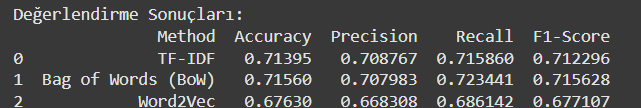

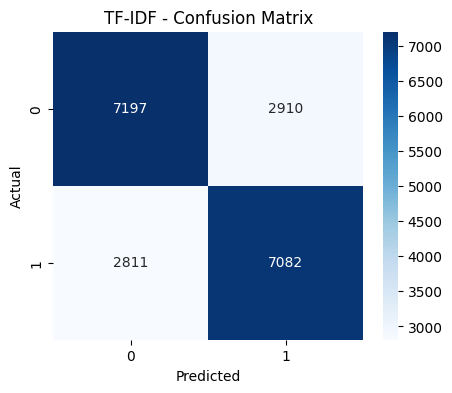

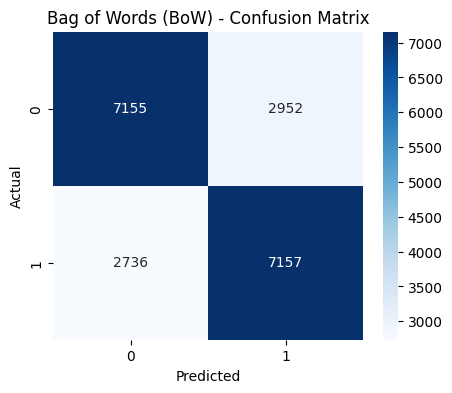

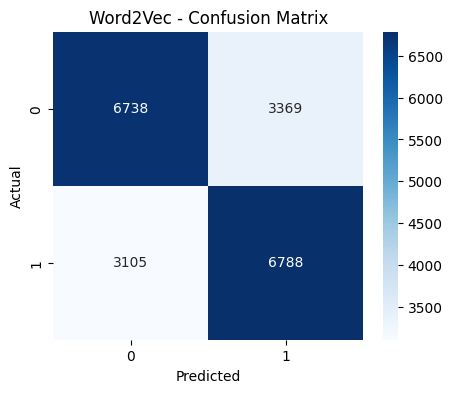

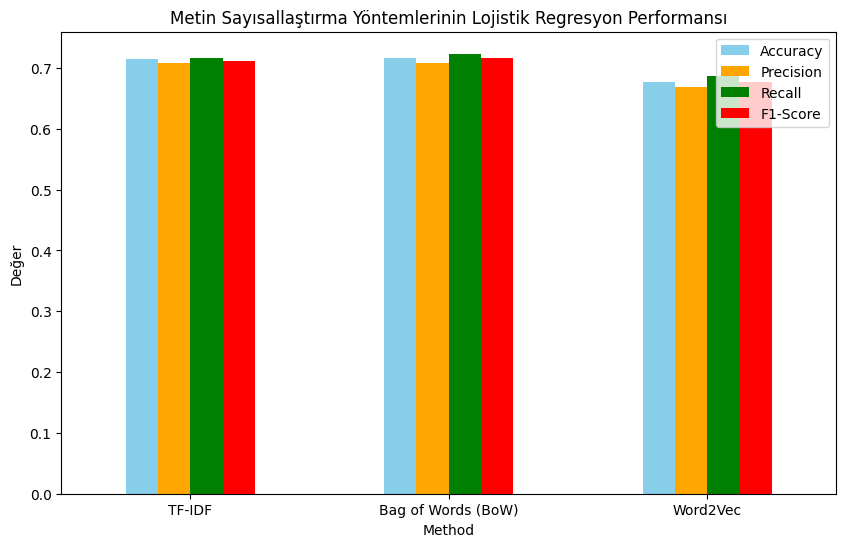

3) Algoritma olarak **Random Forest** kullanıp Özellik Çıkarımı için TF-IDF, Bag of Words ve Word2Vec kıyaslaması yapıldı.

* Cross validation
* Train test split

**Cross validation**

TF-IDF - Cross Validation Mean F1 Score: 0.8435
BoW - Cross Validation Mean F1 Score: 0.8424
Word2Vec - Cross Validation Mean F1 Score: 0.7442


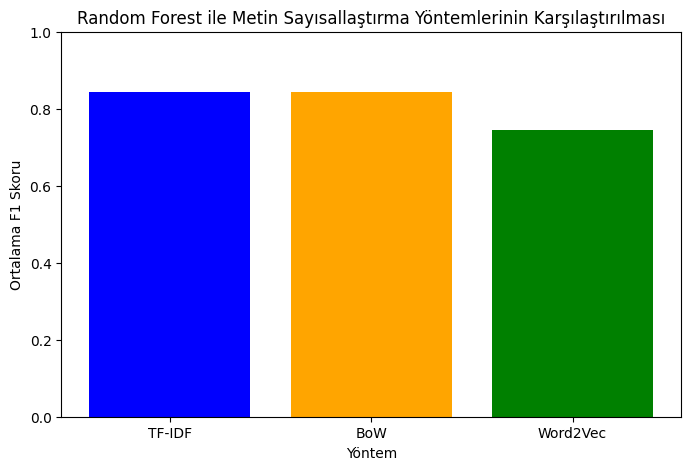

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

# Veri yükleme
file_name = "/content/data.xlsx"
data = pd.read_excel(file_name)

# Hedef sütunu ikili sınıfa çevirme
data['Target'] = data["Eşleşme Oranı (%)"].apply(lambda x: 1 if x > 49 else 0)

# Özellikler ve hedef sütunlar
text_columns = ["Yetenekler", "Konum", "DERECE", "Eğitim Seviyesi", "YETENEKLER", "DİL", "konum", "İstenen Tecrübe"]
numeric_columns = ["Çalışma Şekli2", "Çalışma Türü", "Uzaktan/Normal", "Çalışma Şekli", "ÇALIŞMA ZAMANI (YIL)", "ÖNE ÇIKAN PROJE", "SERTİFİKA ADI", "GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI"]

# Kategorik sütunları sayısallaştırma
data['Uzaktan/Normal'] = data['Uzaktan/Normal'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Şekli2'] = data['Çalışma Şekli2'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Türü'] = data['Çalışma Türü'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})
data['Çalışma Şekli'] = data['Çalışma Şekli'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})

# Random Forest modelini tanımlama ve hiperparametreler
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# BoW (Bag of Words) ile metni sayısallaştırma
bow_vectorizer = CountVectorizer(max_features=100)
bow_features = bow_vectorizer.fit_transform(data[text_columns].astype(str).agg(' '.join, axis=1)).toarray()
bow_df = pd.DataFrame(bow_features, columns=[f'bow_{i}' for i in range(bow_features.shape[1])])

# Word2Vec ile metni sayısallaştırma
def word2vec_transform(texts):
    tokenized_texts = [text.split() for text in texts]
    model = Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
    return np.array([np.mean([model.wv[word] for word in words if word in model.wv], axis=0) for words in tokenized_texts])

word2vec_features = word2vec_transform(data[text_columns].astype(str).agg(' '.join, axis=1))
word2vec_df = pd.DataFrame(word2vec_features, columns=[f'word2vec_{i}' for i in range(word2vec_features.shape[1])])

# TF-IDF ile metni sayısallaştırma
tfidf = TfidfVectorizer(max_features=100)
text_features = tfidf.fit_transform(data[text_columns].astype(str).agg(' '.join, axis=1)).toarray()
text_df = pd.DataFrame(text_features, columns=[f'tfidf_{i}' for i in range(text_features.shape[1])])

# Veriyi hazırlama
X_tfidf = pd.concat([data[numeric_columns].reset_index(drop=True), text_df.reset_index(drop=True)], axis=1)
X_bow = pd.concat([data[numeric_columns].reset_index(drop=True), bow_df.reset_index(drop=True)], axis=1)
X_word2vec = pd.concat([data[numeric_columns].reset_index(drop=True), word2vec_df.reset_index(drop=True)], axis=1)

# Model değerlendirme ve grafik için sonuçları toplama
methods = ['TF-IDF', 'BoW', 'Word2Vec']
X_datasets = [X_tfidf, X_bow, X_word2vec]
f1_scores = []

for method, X_data in zip(methods, X_datasets):
    # Çapraz doğrulama
    cv_scores = cross_val_score(rf_model, X_data, data['Target'], cv=10, scoring='f1')
    mean_f1_score = np.mean(cv_scores)
    f1_scores.append(mean_f1_score)
    print(f"{method} - Cross Validation Mean F1 Score: {mean_f1_score:.4f}")

# Sonuçları görselleştirme
plt.figure(figsize=(8, 5))
plt.bar(methods, f1_scores, color=['blue', 'orange', 'green'])
plt.xlabel('Yöntem')
plt.ylabel('Ortalama F1 Skoru')
plt.title('Random Forest ile Metin Sayısallaştırma Yöntemlerinin Karşılaştırılması')
plt.ylim(0, 1)  # Skorlar 0-1 arasında olduğu için y eksenini sınırlandırıyoruz
plt.show()


*   TF-IDF - Cross Validation Mean F1 Score: 0.8435
*   BoW - Cross Validation Mean F1 Score: 0.8424
* Word2Vec - Cross Validation Mean F1 Score: 0.7442

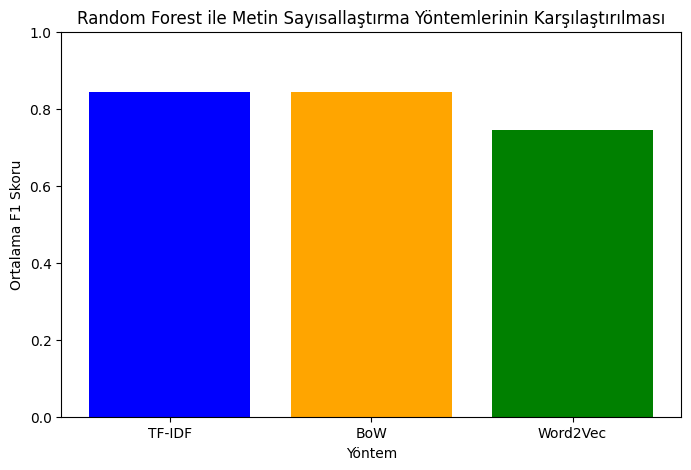

**Train test split**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

# Veri yükleme
file_name = "/content/data.xlsx"
data = pd.read_excel(file_name)

# Hedef sütunu ikili sınıfa çevirme
data['Target'] = data["Eşleşme Oranı (%)"].apply(lambda x: 1 if x > 49 else 0)

# Özellikler ve hedef sütunlar
text_columns = ["Yetenekler", "Konum", "DERECE", "Eğitim Seviyesi", "YETENEKLER", "DİL", "konum", "İstenen Tecrübe"]
numeric_columns = ["Çalışma Şekli2", "Çalışma Türü", "Uzaktan/Normal", "Çalışma Şekli", "ÇALIŞMA ZAMANI (YIL)", "ÖNE ÇIKAN PROJE", "SERTİFİKA ADI", "GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI"]

# Kategorik sütunları sayısallaştırma
data['Uzaktan/Normal'] = data['Uzaktan/Normal'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Şekli2'] = data['Çalışma Şekli2'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Türü'] = data['Çalışma Türü'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})
data['Çalışma Şekli'] = data['Çalışma Şekli'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})

# Text veriyi birleştirme
text_data = data[text_columns].astype(str).agg(' '.join, axis=1)

# Model tanımlama ve değerlendirme
results = []

def train_and_evaluate(X, y, method_name, model):
    global results
    # Veriyi eğitim ve test kümelerine ayırma
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modeli eğitme
    model.fit(X_train, y_train)

    # Test kümesi üzerinde tahmin yapma
    y_pred = model.predict(X_test)

    # Değerlendirme metrikleri
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Sonuçları saklama
    results.append({
        "Method": method_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

    # Karışıklık matrisi görselleştirme
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{method_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Random Forest modelini tanımlama
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 1. TF-IDF
tfidf = TfidfVectorizer(max_features=100)
tfidf_features = tfidf.fit_transform(text_data).toarray()
X_tfidf = pd.concat([data[numeric_columns].reset_index(drop=True).astype(str), pd.DataFrame(tfidf_features)], axis=1)

# Sütun isimlerini string yapma
X_tfidf.columns = X_tfidf.columns.astype(str)
train_and_evaluate(X_tfidf, data['Target'], "TF-IDF", rf_model)

# 2. Bag of Words (BoW)
bow = CountVectorizer(max_features=100)
bow_features = bow.fit_transform(text_data).toarray()
X_bow = pd.concat([data[numeric_columns].reset_index(drop=True).astype(str), pd.DataFrame(bow_features)], axis=1)

# Sütun isimlerini string yapma
X_bow.columns = X_bow.columns.astype(str)
train_and_evaluate(X_bow, data['Target'], "Bag of Words (BoW)", rf_model)

# 3. Word2Vec
text_tokenized = text_data.str.split()
w2v_model = Word2Vec(sentences=text_tokenized, vector_size=100, window=5, min_count=1, workers=4)
w2v_features = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv] or [np.zeros(100)], axis=0) for words in text_tokenized])
X_w2v = pd.concat([data[numeric_columns].reset_index(drop=True).astype(str), pd.DataFrame(w2v_features)], axis=1)

# Sütun isimlerini string yapma
X_w2v.columns = X_w2v.columns.astype(str)
train_and_evaluate(X_w2v, data['Target'], "Word2Vec", rf_model)

# Sonuçları tablo halinde gösterme
results_df = pd.DataFrame(results)
print("\nDeğerlendirme Sonuçları:")
print(results_df)

# Sonuçları görselleştirme
results_df.plot(x="Method", kind="bar", figsize=(10, 6), color=["skyblue", "orange", "green", "red"])
plt.title("Metin Sayısallaştırma Yöntemlerinin Random Forest Performansı")
plt.ylabel("Değer")
plt.xticks(rotation=0)
plt.show()


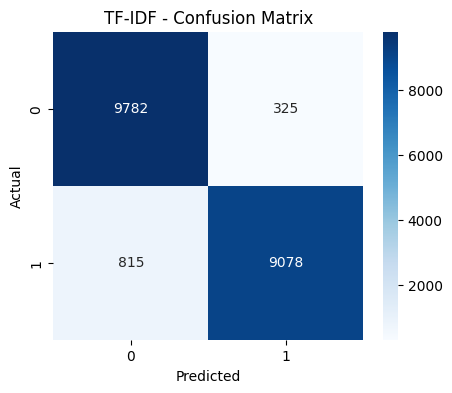

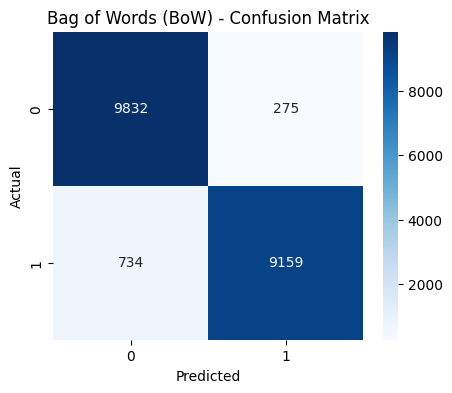

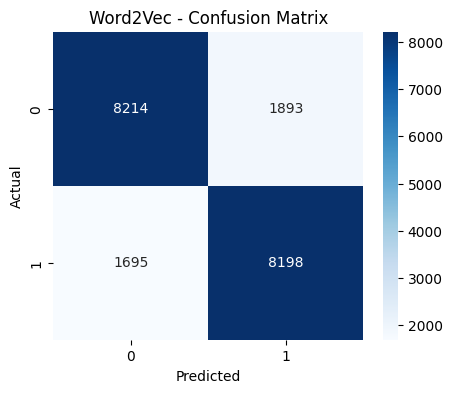

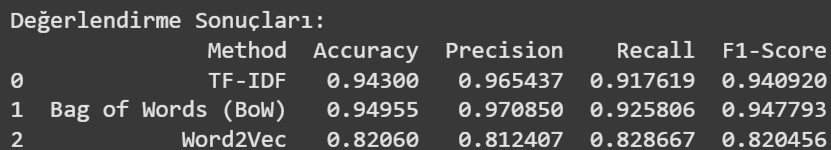


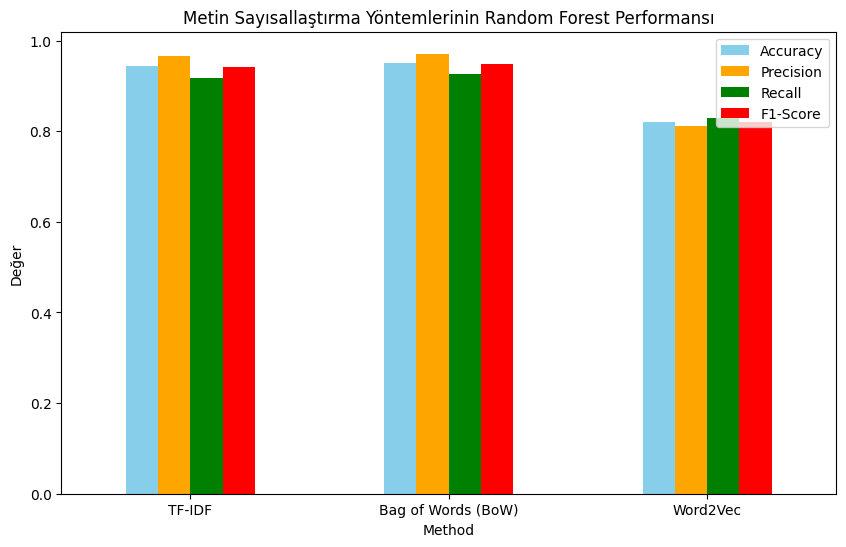

4) Algoritma olarak **Naive Bayes** kullanıp Özellik Çıkarımı için TF-IDF, Bag of Words ve Word2Vec kıyaslaması yapıldı.

* Cross validation
* Train test split

**Cross validation**

TF-IDF - Average F1 Score: 0.6120
Bag of Words (BoW) - Average F1 Score: 0.6509
Word2Vec - Average F1 Score: 0.6049


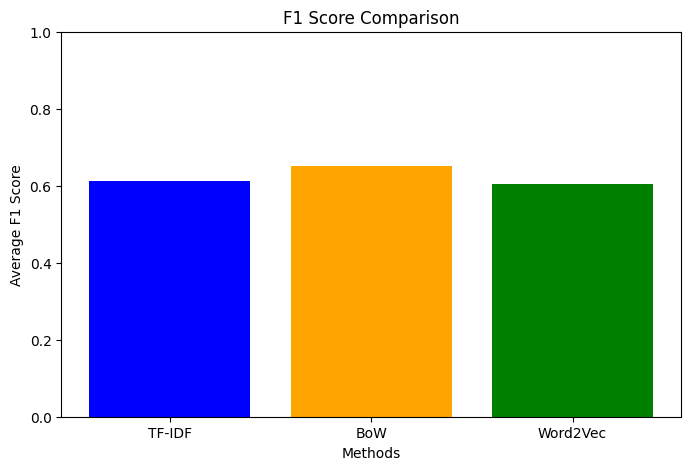

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import make_scorer, f1_score
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

# Veri yükleme
file_name = "/content/data.xlsx"
data = pd.read_excel(file_name)

# Hedef sütunu ikili sınıfa çevirme
data['Target'] = data["Eşleşme Oranı (%)"].apply(lambda x: 1 if x > 49 else 0)

# Özellikler ve hedef sütunlar
text_columns = ["Çalışma Şekli2", "Çalışma Türü", "Uzaktan/Normal", "Çalışma Şekli", "Yetenekler", "Konum", "DERECE", "Eğitim Seviyesi", "YETENEKLER", "DİL", "konum", "İstenen Tecrübe"]
numeric_columns = ["ÇALIŞMA ZAMANI (YIL)", "ÖNE ÇIKAN PROJE", "SERTİFİKA ADI", "GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI"]

# Text veriyi birleştirme
text_data = data[text_columns].astype(str).agg(' '.join, axis=1)

# Model tanımlama ve çapraz doğrulama fonksiyonu
def train_and_evaluate_cv(X, y, method_name):
    # Naive Bayes modelini tanımlama
    nb_model = MultinomialNB()

    # F1 skoru hesaplama
    f1 = cross_val_score(nb_model, X, y, cv=5, scoring=make_scorer(f1_score)).mean()

    print(f"{method_name} - Average F1 Score: {f1:.4f}")
    return f1

# 1. TF-IDF
tfidf = TfidfVectorizer(max_features=100)
tfidf_features = tfidf.fit_transform(text_data).toarray()
X_tfidf = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(tfidf_features)], axis=1)
X_tfidf.columns = X_tfidf.columns.astype(str)  # Sütun isimlerini string'e dönüştürme

f1_tfidf = train_and_evaluate_cv(X_tfidf, data['Target'], "TF-IDF")

# 2. Bag of Words (BoW)
bow = CountVectorizer(max_features=100)
bow_features = bow.fit_transform(text_data).toarray()
X_bow = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(bow_features)], axis=1)
X_bow.columns = X_bow.columns.astype(str)  # Sütun isimlerini string'e dönüştürme

f1_bow = train_and_evaluate_cv(X_bow, data['Target'], "Bag of Words (BoW)")

# 3. Word2Vec
text_tokenized = text_data.str.split()
w2v_model = Word2Vec(sentences=text_tokenized, vector_size=100, window=5, min_count=1, workers=4)
w2v_features = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv] or [np.zeros(100)], axis=0) for words in text_tokenized])

# Word2Vec özelliklerinden negatif değerleri sıfırlama
w2v_features[w2v_features < 0] = 0

X_w2v = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(w2v_features)], axis=1)
X_w2v.columns = X_w2v.columns.astype(str)  # Sütun isimlerini string'e dönüştürme

f1_w2v = train_and_evaluate_cv(X_w2v, data['Target'], "Word2Vec")

# Sonuçları karşılaştırma
def plot_results(results):
    methods = list(results.keys())
    scores = list(results.values())

    plt.figure(figsize=(8, 5))
    plt.bar(methods, scores, color=['blue', 'orange', 'green'])
    plt.title('F1 Score Comparison')
    plt.xlabel('Methods')
    plt.ylabel('Average F1 Score')
    plt.ylim(0, 1)
    plt.show()

results = {
    "TF-IDF": f1_tfidf,
    "BoW": f1_bow,
    "Word2Vec": f1_w2v
}

plot_results(results)


* TF-IDF - Average F1 Score: 0.6120
* Bag of Words (BoW) - Average F1 Score: 0.6509
* Word2Vec - Average F1 Score: 0.6049

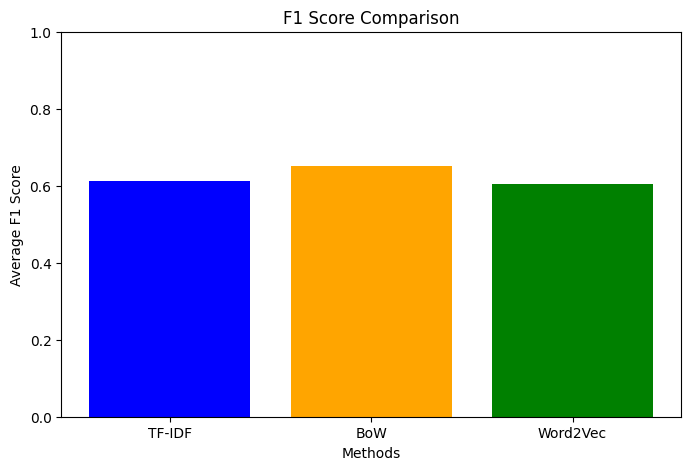

**Train test split**


TF-IDF Performance:
Accuracy: 0.6299, Precision: 0.6357, Recall: 0.5897, F1-Score: 0.6118


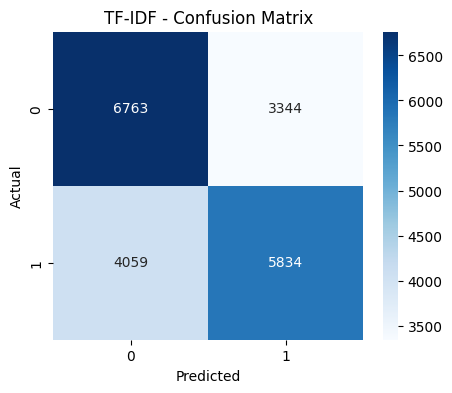


Bag of Words (BoW) Performance:
Accuracy: 0.6490, Precision: 0.6390, Recall: 0.6675, F1-Score: 0.6530


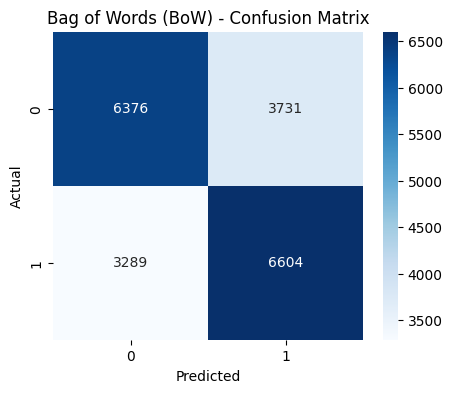


Word2Vec Performance:
Accuracy: 0.6126, Precision: 0.6145, Recall: 0.5816, F1-Score: 0.5976


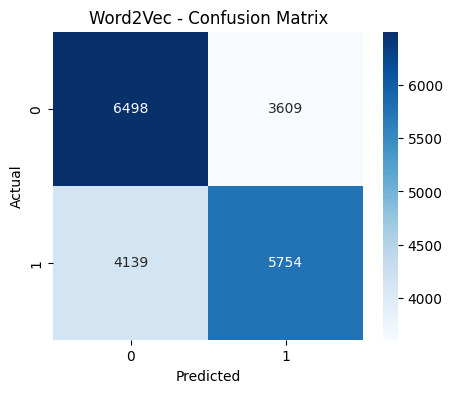

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

# Veri yükleme
file_name = "/content/data.xlsx"
data = pd.read_excel(file_name)

# Hedef sütunu ikili sınıfa çevirme
data['Target'] = data["Eşleşme Oranı (%)"].apply(lambda x: 1 if x > 49 else 0)

# Özellikler ve hedef sütunlar
text_columns = ["Çalışma Şekli2", "Çalışma Türü", "Uzaktan/Normal", "Çalışma Şekli", "Yetenekler", "Konum", "DERECE", "Eğitim Seviyesi", "YETENEKLER", "DİL", "konum", "İstenen Tecrübe"]
numeric_columns = ["ÇALIŞMA ZAMANI (YIL)", "ÖNE ÇIKAN PROJE", "SERTİFİKA ADI", "GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI"]

# Text veriyi birleştirme
text_data = data[text_columns].astype(str).agg(' '.join, axis=1)

# Model tanımlama
def train_and_evaluate(X, y, method_name):
    # Veriyi eğitim ve test kümelerine ayırma
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Naive Bayes modelini eğitme
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)

    # Test kümesi üzerinde tahmin yapma
    y_pred = nb_model.predict(X_test)

    # Değerlendirme metrikleri
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{method_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Karışıklık matrisi görselleştirme
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{method_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 1. TF-IDF
tfidf = TfidfVectorizer(max_features=100)
tfidf_features = tfidf.fit_transform(text_data).toarray()
X_tfidf = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(tfidf_features)], axis=1)
X_tfidf.columns = X_tfidf.columns.astype(str)  # Sütun isimlerini string'e dönüştürme
train_and_evaluate(X_tfidf, data['Target'], "TF-IDF")

# 2. Bag of Words (BoW)
bow = CountVectorizer(max_features=100)
bow_features = bow.fit_transform(text_data).toarray()
X_bow = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(bow_features)], axis=1)
X_bow.columns = X_bow.columns.astype(str)  # Sütun isimlerini string'e dönüştürme
train_and_evaluate(X_bow, data['Target'], "Bag of Words (BoW)")

# 3. Word2Vec
text_tokenized = text_data.str.split()
w2v_model = Word2Vec(sentences=text_tokenized, vector_size=100, window=5, min_count=1, workers=4)
w2v_features = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv] or [np.zeros(100)], axis=0) for words in text_tokenized])

# Word2Vec özelliklerinden negatif değerleri sıfırlama
w2v_features[w2v_features < 0] = 0

X_w2v = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(w2v_features)], axis=1)
X_w2v.columns = X_w2v.columns.astype(str)  # Sütun isimlerini string'e dönüştürme
train_and_evaluate(X_w2v, data['Target'], "Word2Vec")



* **TF-IDF Performance**:
Accuracy: 0.6299, Precision: 0.6357, Recall: 0.5897, F1-Score: 0.6118
* **Bag of Words (BoW) Performance**:
Accuracy: 0.6490, Precision: 0.6390, Recall: 0.6675, F1-Score: 0.6530
* **Word2Vec Performance**:
Accuracy: 0.6126, Precision: 0.6145, Recall: 0.5816, F1-Score: 0.5976

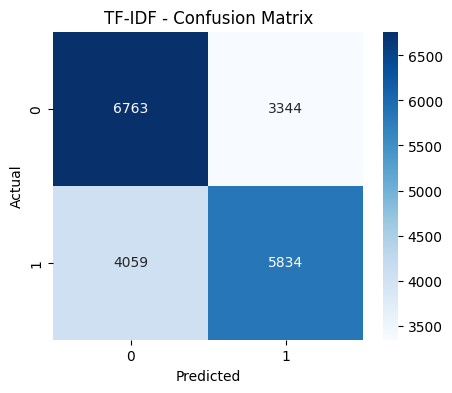

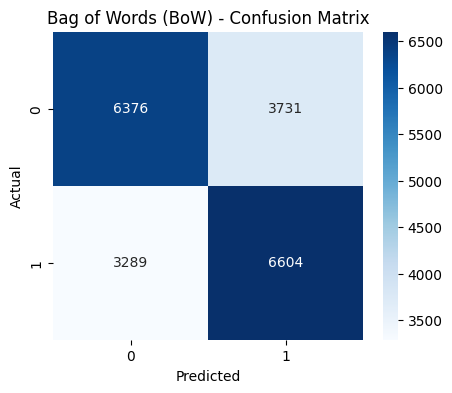

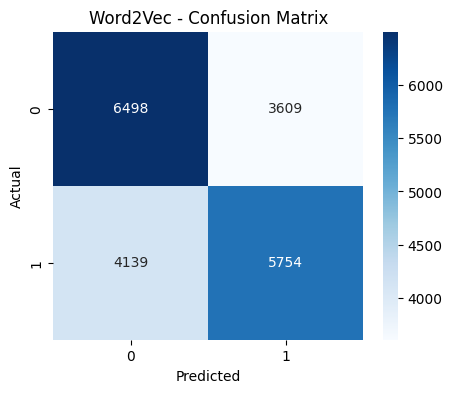

5) Algoritma olarak **LSTM** kullanıp Özellik Çıkarımı için TF-IDF, Bag of Words ve Word2Vec kıyaslaması yapıldı.

* Cross validation
* Train test split

**Train test split**

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Veri yükleme
file_name = "/content/data.xlsx"
data = pd.read_excel(file_name)

# Hedef sütunu ikili sınıfa çevirme
data['Target'] = data["Eşleşme Oranı (%)"].apply(lambda x: 1 if x > 49 else 0)

# Özellikler ve hedef sütunlar
text_columns = ["Yetenekler", "Konum", "DERECE", "Eğitim Seviyesi", "YETENEKLER", "DİL", "konum", "İstenen Tecrübe"]
numeric_columns = ["Çalışma Şekli2", "Çalışma Türü", "Uzaktan/Normal", "Çalışma Şekli", "ÇALIŞMA ZAMANI (YIL)", "ÖNE ÇIKAN PROJE", "SERTİFİKA ADI", "GÖNÜLLÜLÜK YAPTIĞI ORGANİZASYON ADI"]

# Kategorik sütunları sayısallaştırma
data['Uzaktan/Normal'] = data['Uzaktan/Normal'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Şekli2'] = data['Çalışma Şekli2'].map({'İş Yeri': 0, 'Uzaktan': 1, 'Hibrit': 2})
data['Çalışma Türü'] = data['Çalışma Türü'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})
data['Çalışma Şekli'] = data['Çalışma Şekli'].map({'Tam Zamanlı': 0, 'Yarı Zamanlı': 1, 'Sözleşmeli': 2, 'Stajyer': 3})

# Text veriyi birleştirme
text_data = data[text_columns].astype(str).agg(' '.join, axis=1)

# LSTM için metin verisini hazırlama
def prepare_lstm_input(text_data, max_length=100):
    # Metin verisini tokenize etme
    tokenized_texts = [text.split() for text in text_data]

    # Keras Tokenizer'ı kullanarak her kelimenin indeksini oluşturuyoruz
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(text_data)
    sequences = tokenizer.texts_to_sequences(text_data)

    # Veriyi sabit uzunlukta hale getirmek için padding işlemi yapıyoruz
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_length)

    return padded_sequences, tokenizer

# LSTM Modelini tanımlama
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=100, input_length=input_shape))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Modeli eğitme ve değerlendirme
def train_and_evaluate(X, y, method_name):
    # Veriyi eğitim ve test kümelerine ayırma
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # LSTM modelini oluşturma
    lstm_model = create_lstm_model(X_train.shape[1])

    # LSTM modelini eğitme
    lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=1)

    # Test kümesi üzerinde tahmin yapma
    y_pred = (lstm_model.predict(X_test) > 0.5).astype(int)

    # Değerlendirme metrikleri
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{method_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Karışıklık matrisi görselleştirme
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{method_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 1. TF-IDF
tfidf = TfidfVectorizer(max_features=100)
tfidf_features = tfidf.fit_transform(text_data).toarray()
X_tfidf = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(tfidf_features)], axis=1)
X_tfidf_lstm, tokenizer_tfidf = prepare_lstm_input(text_data)
train_and_evaluate(X_tfidf_lstm, data['Target'], "TF-IDF")

# 2. Bag of Words (BoW)
bow = CountVectorizer(max_features=100)
bow_features = bow.fit_transform(text_data).toarray()
X_bow = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(bow_features)], axis=1)
X_bow_lstm, tokenizer_bow = prepare_lstm_input(text_data)
train_and_evaluate(X_bow_lstm, data['Target'], "Bag of Words (BoW)")

# 3. Word2Vec
text_tokenized = text_data.str.split()
w2v_model = Word2Vec(sentences=text_tokenized, vector_size=100, window=5, min_count=1, workers=4)
w2v_features = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv] or [np.zeros(100)], axis=0) for words in text_tokenized])
X_w2v = pd.concat([data[numeric_columns].reset_index(drop=True), pd.DataFrame(w2v_features)], axis=1)
X_w2v_lstm, tokenizer_w2v = prepare_lstm_input(text_data)
train_and_evaluate(X_w2v_lstm, data['Target'], "Word2Vec")



1.   **TF-IDF Performance:**
Accuracy: 0.9389, Precision: 0.9537, Recall: 0.9214, F1-Score: 0.9372

* Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 135ms/step - accuracy: 0.6876 - loss: 0.5870 - val_accuracy: 0.8104 - val_loss: 0.4668
* Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 192s 131ms/step - accuracy: 0.8122 - loss: 0.4456 - val_accuracy: 0.8465 - val_loss: 0.3899
* Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 163s 131ms/step - accuracy: 0.8478 - loss: 0.3846 - val_accuracy: 0.9022 - val_loss: 0.2726
* Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 202s 131ms/step - accuracy: 0.9121 - loss: 0.2492 - val_accuracy: 0.9383 - val_loss: 0.1824
*Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 162s 130ms/step - accuracy: 0.9347 - loss: 0.1840 - val_accuracy: 0.9390 - val_loss: 0.1628
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step

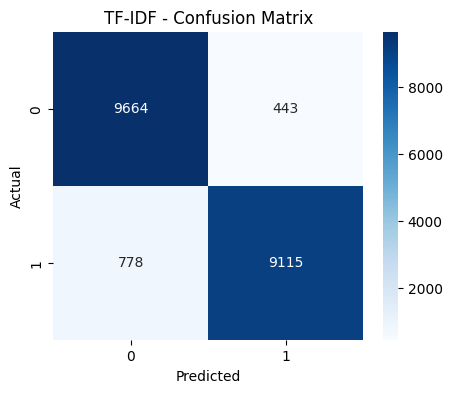

2. Bag of Words (BoW) Performance:
Accuracy: 0.9526, Precision: 0.9753, Recall: 0.9275, F1-Score: 0.9508

* Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 161s 128ms/step - accuracy: 0.6581 - loss: 0.5961 - val_accuracy: 0.7662 - val_loss: 0.4775
* Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 203s 129ms/step - accuracy: 0.7789 - loss: 0.4531 - val_accuracy: 0.9227 - val_loss: 0.2019
* Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 159s 127ms/step - accuracy: 0.9291 - loss: 0.1866 - val_accuracy: 0.9321 - val_loss: 0.1648
* Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 159s 127ms/step - accuracy: 0.9369 - loss: 0.1500 - val_accuracy: 0.9479 - val_loss: 0.1282
* Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 159s 127ms/step - accuracy: 0.9453 - loss: 0.1299 - val_accuracy: 0.9525 - val_loss: 0.1162
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step

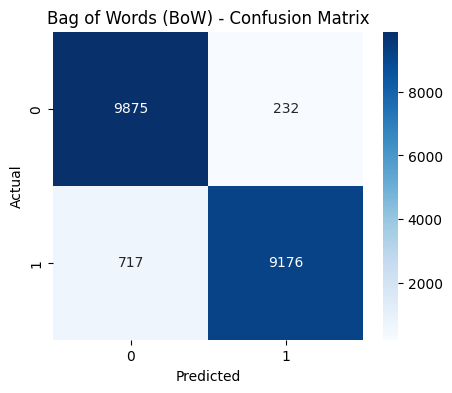

3. Word2Vec Performance:
Accuracy: 0.9397, Precision: 0.9457, Recall: 0.9316, F1-Score: 0.938

* Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 167s 133ms/step - accuracy: 0.6417 - loss: 0.6229 - val_accuracy: 0.8199 - val_loss: 0.4376

* Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 199s 131ms/step - accuracy: 0.8307 - loss: 0.4102 - val_accuracy: 0.9118 - val_loss: 0.2502

* Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 202s 131ms/step - accuracy: 0.9140 - loss: 0.2448 - val_accuracy: 0.9369 - val_loss: 0.1843

* Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 165s 132ms/step - accuracy: 0.9328 - loss: 0.1892 - val_accuracy: 0.9402 - val_loss: 0.1624
* Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 201s 131ms/step - accuracy: 0.9382 - loss: 0.1655 - val_accuracy: 0.9397 - val_loss: 0.1532
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step

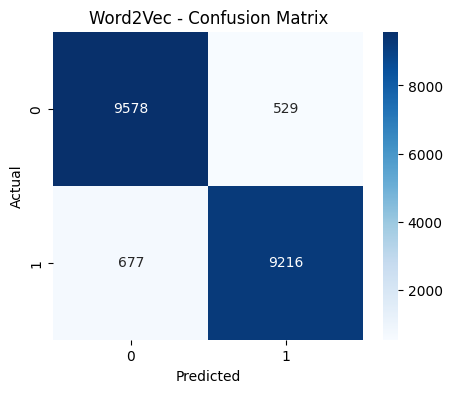